## Import libraries


In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load and preprocess data


In [91]:
# Load data
btc_data = pd.read_parquet("../datasets/BTCUSDT/")
btc_data.index = pd.to_datetime(btc_data.index, unit="ms")
btc_data.drop(
    columns=[
        "TAKER_BUY_BASE_ASSET_VOLUME",
        "TAKER_BUY_QUOTE_ASSET_VOLUME",
        "YEAR_AND_MONTH",
    ],
    inplace=True,
)

In [92]:
# Load labels
labels = pd.read_parquet("../datasets/LABEL_BTCUSDT/")
labels.index = pd.to_datetime(labels.index, unit="ms")
labels.drop(columns="SYMBOL", inplace=True)

In [93]:
labels

,LABEL
OPEN_TIME,
2017-09-16 10:00:00,0.394465
2017-09-16 11:00:00,0.390792
2017-09-16 12:00:00,0.360976
2017-09-16 13:00:00,0.398855
2017-09-16 14:00:00,0.451953
...,...
2023-07-25 12:00:00,0.404414
2023-07-25 13:00:00,0.418165
2023-07-25 14:00:00,0.418191


In [5]:
btc_data.loc[pd.Timestamp("2017-12-18 12:00:00") :].head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES
OPEN_TIME,,,,,,,
2017-12-18 12:00:00,19116.11,19199.00,19114.97,19152.00,64.422665,1.233095e+06,343
2017-12-18 12:05:00,19175.00,19198.97,19116.98,19180.00,19.845825,3.802186e+05,284
2017-12-18 12:10:00,19180.00,19300.00,19116.13,19212.23,44.649825,8.568738e+05,410
2017-12-18 12:15:00,19212.23,19212.26,19143.50,19179.99,42.377449,8.128457e+05,288
2017-12-18 12:20:00,19179.99,19197.88,19114.97,19114.97,33.430487,6.407821e+05,338


## Calculate typical price and handle missing timestamps


In [95]:
btc_price = pd.DataFrame(
    index=pd.date_range(start=btc_data.index[0], end=btc_data.index[-1], freq="5min")
)
btc_price["PRICE"] = (btc_data["HIGH"] + btc_data["LOW"] + btc_data["CLOSE"]) / 3
btc_price.interpolate(method="time", inplace=True)

## Probability of the price using Geometric Brownian Motion


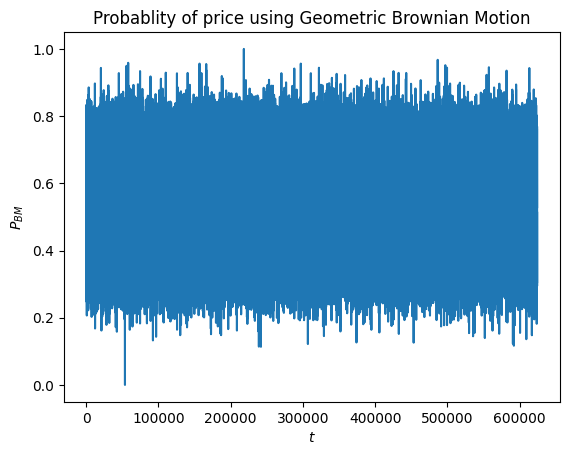

In [96]:
mu = 0.1
n = btc_price.shape[0]
dt = 1e-5
x0 = 1
sigma = 0.3
np.random.seed(1012)
p_bm = np.exp((mu - sigma**2 / 2) * dt + sigma * np.random.normal(0, dt, n))
p_bm = MinMaxScaler().fit_transform(p_bm.reshape(-1, 1)).flatten()
btc_price["P_BM"] = p_bm
plt.plot(p_bm)
plt.xlabel("$t$")
plt.ylabel("$P_{BM}$")
plt.title("Probablity of price using Geometric Brownian Motion")
plt.show()

## Pipeline for scaling labels

In [97]:
price_pipline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
)

## Calculate return rate (R) and price volatility change (V)


In [98]:
def r_v(i, btc_price: pd.DataFrame):
    # R
    btc_price["R"] = 100 * \
        (btc_price["PRICE"].shift(-i) / btc_price["PRICE"] - 1)

    # V
    std_backward = SimpleImputer(strategy="mean").fit_transform(
        btc_price["PRICE"].rolling(round(1.5 * i)).std().values.reshape(-1, 1)
    )
    std_forward = SimpleImputer(strategy="mean").fit_transform(
        btc_price["PRICE"].rolling(i).std().shift(-i).values.reshape(-1, 1)
    )
    btc_price["V"] = std_forward / std_backward
    return btc_price[["R", "V"]]

In [100]:
btc_price = r_v(60, btc_price)

In [101]:
btc_price

,R,V
2017-08-17 04:00:00,2.175574,0.210573
2017-08-17 04:05:00,2.311873,0.206285
2017-08-17 04:10:00,2.311873,0.201166
2017-08-17 04:15:00,2.284670,0.195484
2017-08-17 04:20:00,2.207782,0.189831
...,...,...
2023-07-24 08:40:00,NaN,1.956044
2023-07-24 08:45:00,NaN,2.064418
2023-07-24 08:50:00,NaN,2.171652
2023-07-24 08:55:00,NaN,2.293708


## Define function for predicting labels

In [10]:
def predict(data: pd.Series, time: pd.DatetimeIndex, file_name: str):
    agg_data = data.resample('H').mean().shift(1).loc[time]
    predict_labels = agg_data["R"] / (2 * np.sqrt(agg_data["V"] * agg_data["P_BM"]))
    labels = price_pipline.fit_transform(predict_labels.values.reshape(-1, 1)).flatten()
    submission = pd.DataFrame(
        {"OPEN_TIME": time.astype(np.int64) // 10**6, "PREDICTION": labels}
    )
    submission.to_csv("C:/Users/nguye/Downloads/" + file_name, index=False)
    sns.kdeplot(labels, fill=True)
    return labels

## Prediction for public test round


array([0.32598842, 0.26835637, 0.34535599, ..., 0.47561184, 0.45878067,
       0.43802585])

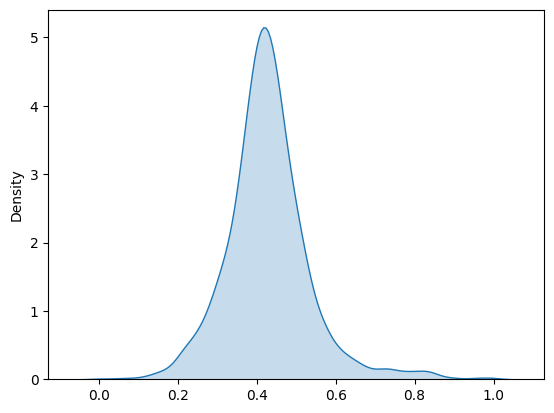

In [11]:
predict(
    btc_price,
    pd.date_range(start="2022-12-15", end="2023-03-05", freq="H"),
    "public_test_v5.csv",
)

## Prediction for private test round

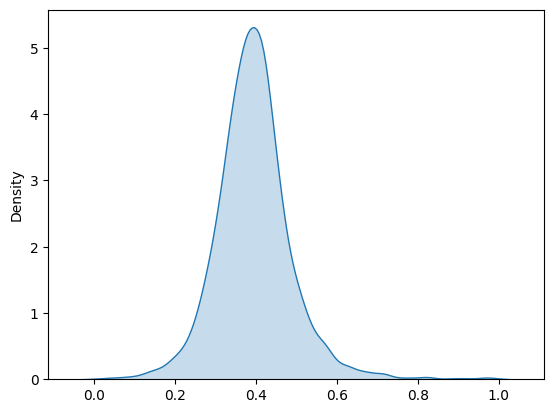

In [133]:
lb = predict(
    btc_price,
    pd.date_range(start="2023-02-01", end="2023-06-15", freq="H"),
    "private_test_22_7.csv",
)

## Predict by using calculated labels

In [14]:
# def pred_v2(time,file_name):
#     resample_data = cal_labels.resample("30min").mean()
#     lb = price_pipline.fit_transform(resample_data.loc[time].values.reshape(-1, 1)).flatten()
#     x = pd.DataFrame(
#         {"OPEN_TIME": time.astype(np.int64) // 10**6, "PREDICTION": lb}
#     )
#     x.to_csv("C:/Users/nguye/Downloads/" + file_name, index=False)
#     sns.kdeplot(lb, fill=True)
#     plt.show()


In [15]:
# pred_v2(
#     pd.date_range(start="2022-12-15", end="2023-03-05", freq="H"),
#     "public_test_v6.csv",
# )

In [16]:
# pred_v2(
#     pd.date_range(start="2023-02-01", end="2023-06-15", freq="H"),
#     "private_test_22_7_v2.csv",
# )

In [12]:
agg_data = btc_price.resample('H').mean().shift(1).loc[pd.Timestamp("2020-07-01 00:00:00") :]
data = pd.DataFrame(
    index=agg_data.index, data={"R": agg_data["R"], "V": agg_data["V"]}
)

In [13]:
data['R'][abs(data['R'])>10] = data['R'].median()

In [74]:
pred_labels = data["R"] / (2 * np.sqrt(data["V"] * agg_data["P_BM"]))

In [23]:
s = MinMaxScaler()
k = s.fit_transform(pred_labels.values.reshape(-1, 1)).flatten()

In [72]:
# descale with numpy
x = k * (s.data_max_ - s.data_min_) + s.data_min_ 
x

array([-0.00830216,  0.46791845,  0.36112607, ..., -0.46818095,
       -0.44184655, -0.50214027])

In [79]:
s.data_max_, s.data_min_ 
scale = (pred_labels[0] - s.data_min_) / (s.data_max_ - s.data_min_)
scale * (s.data_max_ - s.data_min_) + s.data_min_
scale

array([0.46654576])

In [77]:
pred_labels

2020-07-01 00:00:00   -0.008302
2020-07-01 01:00:00    0.467918
2020-07-01 02:00:00    0.361126
2020-07-01 03:00:00    0.111048
2020-07-01 04:00:00    0.183392
                         ...   
2023-07-23 20:00:00   -0.812430
2023-07-23 21:00:00   -0.632809
2023-07-23 22:00:00   -0.468181
2023-07-23 23:00:00   -0.441847
2023-07-24 00:00:00   -0.502140
Freq: H, Length: 26833, dtype: float64

In [47]:
39 - -23

62

In [34]:
# data.to_csv("C:/Users/nguye/Downloads/data.csv")
pred_labels.to_csv("C:/Users/nguye/Downloads/labels.csv")

In [35]:
pred_labels

2020-07-01 00:00:00   -0.008302
2020-07-01 01:00:00    0.467918
2020-07-01 02:00:00    0.361126
2020-07-01 03:00:00    0.111048
2020-07-01 04:00:00    0.183392
                         ...   
2023-07-23 20:00:00   -0.812430
2023-07-23 21:00:00   -0.632809
2023-07-23 22:00:00   -0.468181
2023-07-23 23:00:00   -0.441847
2023-07-24 00:00:00   -0.502140
Freq: H, Length: 26833, dtype: float64

In [106]:
submit_hour = (pd.Timestamp.now().ceil(freq="H") - pd.Timedelta(hours=7)).value // 10**6
print(submit_hour)


1690117200000


In [85]:
x = MinMaxScaler().fit_transform(pred_labels.values.reshape(-1,1)).flatten()